# Analysis of model data

A quick exploratory analysis of datasets obtained from Victor D. 

## Import modules and define functions

In [2]:
%matplotlib inline
import scipy
from scipy import stats as st
import pynbody as pb
from datetime import datetime
from xml.etree.ElementInclude import include
from matplotlib.colors import LogNorm
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

model_dir = 'run732HF/'
#model_dir = 'SB_models/'
#model_dir = 'SB_nogas_models/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/code/images4thesis/' + model_dir
# param_fname = base_dir + 'run732HF.param'

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def bar_align(galaxy, rbar, barfrac = 0.5, zlim=0.5, log=False):
    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} '.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees'.format(r_angle))

    return None

def pbload(filename, paramname=None, log=False):
    if log:
        print('* Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    if log:
        print('* Centering the data...')
    pb.analysis.angmom.faceon(sim)
    bar_align(sim,3.,barfrac=1.,zlim=0.5,log=log)
    return sim

def load_data_lst():
    s_lst = []
    for snap in snap_lst:
        
        snap_name = snap.replace('.gz','')
        
        param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
        #print(param_fname[0])
        
        s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]))
        pb.analysis.angmom.faceon(s)
        bar_align(s,3.,barfrac=1.,zlim=0.5,log=True)
        s_lst.append(s)
    return(s_lst)

def list_snaps(base_dir):
    import os
    # list to store files
    snap_lst = []
    param_lst = []
    # Iterate directory
    for path in os.listdir(base_dir):
        # check if current path is a file
        if os.path.isfile(os.path.join(base_dir, path)) and '.gz' in path:
            snap_lst.append(path)
        elif os.path.isfile(os.path.join(base_dir, path)) and '.param' in path:
            param_lst.append(path)
    return(sorted(snap_lst),sorted(param_lst))

snap_lst , param_lst = list_snaps(base_dir)
print(snap_lst)
print(param_lst)


['run732HF.01200.gz', 'run732HF.01210.gz', 'run732HF.01220.gz', 'run732HF.01230.gz', 'run732HF.01240.gz', 'run732HF.01250.gz', 'run732HF.01260.gz', 'run732HF.01270.gz', 'run732HF.01280.gz', 'run732HF.01290.gz', 'run732HF.01300.gz', 'run732HF.01310.gz', 'run732HF.01320.gz', 'run732HF.01330.gz', 'run732HF.01340.gz', 'run732HF.01350.gz', 'run732HF.01360.gz', 'run732HF.01370.gz', 'run732HF.01380.gz', 'run732HF.01390.gz']
['run732HF.param']


## Binned 2d-statistics for number density and velocity

### Number density

#### Face-on - inner bar development

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656133 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.69997384566695 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01280.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 179.4765536288629 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 84.71445997281806 degrees
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* 

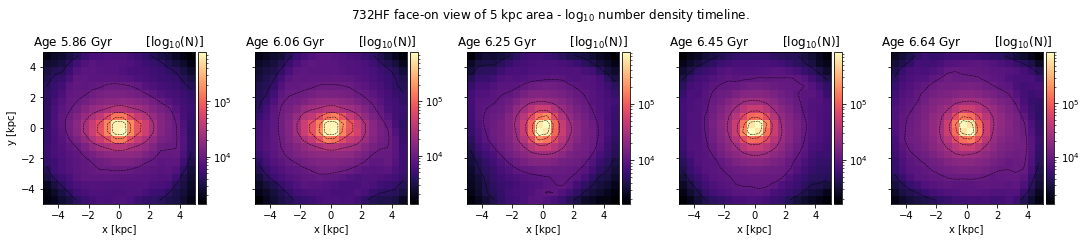

In [ ]:
# Zoom in
# Nuclear bar
#xlim, ylim = 1, 1 #kpc
# Primary bar
xlim, ylim = 5, 5 #kpc
bins = 20
cmap = 'magma'
plt_title = ' face-on view of ' + str(xlim) + ' kpc area' + ' - log$_{10}$ density timeline.'

step = 4
iter = int(len(snap_lst)/step)
iter_lst = []
for k in range(iter):
    iter_lst.append(k*step)

panels = iter
figsize_x = 3*panels
figsize_y = 3.5
# make the figure and sub plots
fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))

i = 0
j = 0

for snap in snap_lst:

    if j in iter_lst:
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        s = pbload(base_dir + snap,param_fname,log=True)
      
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                statistic = 'count',
                                range = [[-xlim,xlim],[-ylim,ylim]],
                                bins = bins)
    
        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
        xcent = (xedges[1:] + xedges[:-1]) / 2
        ycent = (yedges[1:] + yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
        splt_title = 'Age ' + str(age) + ' Gyr' + '         [log$_{10}$(N)]'
        axes[i].title.set_text(splt_title)
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(image, cax=cax, orientation='vertical')
        #cbar.set_label(cbar_label_lst[i])
        if i > 0:
            axes[i].set_yticklabels([])
        i = i + 1
        j += 1
    else: 
        j += 1

fig.tight_layout()
fig.suptitle(snap.replace(".gz","") + plt_title)
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig(image_dir + '_face_on_num_density_' + str(xlim) + 'kpc' + '.png')
print('* Done!')
plt.show()


### Velocity distribution

#### Load data

In [2]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s_lst = load_data_lst()

Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01270 ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 46.977492810664934 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310 ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 127.40061832790695 degrees*
Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01260 ...
Done!
* Bar defined, aligning to 3.0 kpc *
* Realigning bar using |z| < 0.5 *
* Bar realigned by 103.18405996483067 degrees*


#### Mean velocity for inclination 45 deg and different relative PA angles

/tmp/ipykernel_376/579607696.py:45: RuntimeWarning: invalid value encountered in log10
  axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')


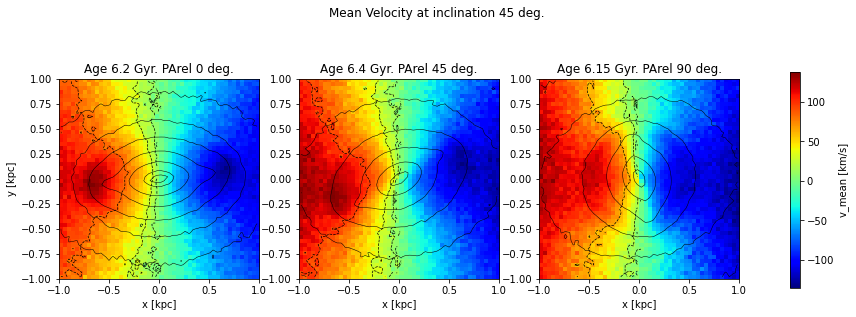

In [18]:
# Zoom in
#xy_lim = [[5,5],[1,1],[0.5,0.5]] #kpc
#xlim, ylim = 0.5, 0.5 #kpc
xlim, ylim = 1, 1 #kpc
#xlim, ylim = 3, 3 #kpc
plt_title = 'Mean velocity'
cbar_label = 'v_mean [km/s]'
bins = 50
cmap = 'jet'

# make the figure and sub plots
fig,axes = plt.subplots(1,3,figsize=(14,5))
incl = 45

i = 0
for s in s_lst:

    age = round(s.properties['time'].in_units('Gyr'),2)

    s.rotate_x(-incl)
        
    d_stat2d,d_xedges,d_yedges,d_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        
    stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

    image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)

    axes[i].title.set_text('Age ' + str(age) + ' Gyr.' + ' PArel ' + str(45*i) + ' deg.')

    xcent = (d_xedges[1:] + d_xedges[:-1]) / 2
    ycent = (d_yedges[1:] + d_yedges[:-1]) / 2
    axes[i].contour(xcent, ycent, np.log10(d_stat2d.T), linewidths = 0.5, colors = 'k')
    
    xcent = (xedges[1:] + xedges[:-1]) / 2
    ycent = (yedges[1:] + yedges[:-1]) / 2
    axes[i].contour(xcent, ycent, np.log10(stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
    
    i = i + 1
    
    s.rotate_x(incl) # Rotate back to original position
    
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = fig.colorbar(image, cax = cbar_ax)
cbar.set_label(cbar_label)
fig.suptitle(plt_title + ' at inclination ' + str(incl) + ' deg.')
plt.setp(axes[:], xlabel = 'x [kpc]')
plt.setp(axes[0], ylabel = 'y [kpc]')
plt.savefig('run732HF_losv_mean.png')
plt.show()


#### Velocity dispersion for different relative PA and inclinations

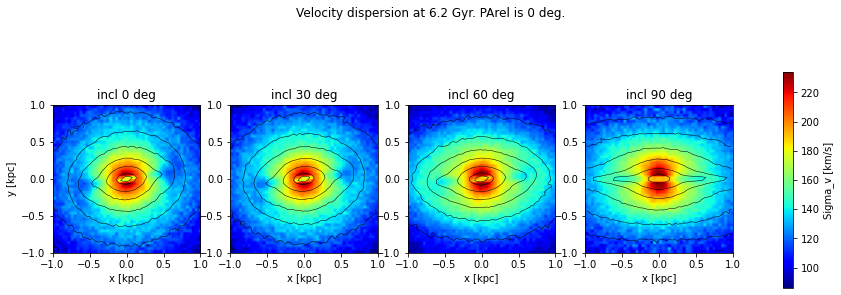

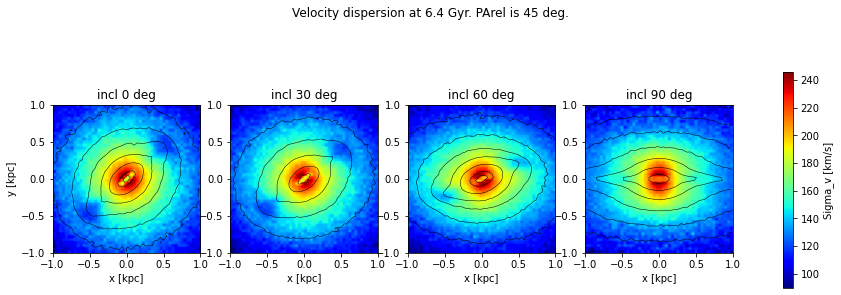

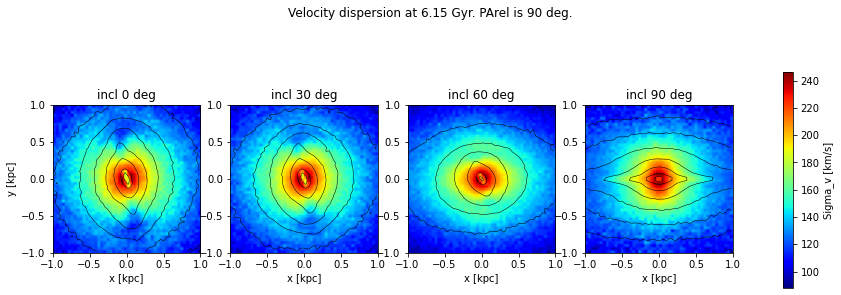

In [14]:
# Zoom in
#xy_lim = [[5,5],[1,1],[0.5,0.5]] #kpc
#xlim, ylim = 0.5, 0.5 #kpc
xlim, ylim = 1, 1 #kpc
#xlim, ylim = 3, 3 #kpc
plt_title = 'Velocity dispersion'
cbar_label = 'Sigma_v [km/s]'
bins = 50
cmap = 'jet'

j = 0
for s in s_lst:
    
    incl_lst = [0,30,60,90]
    # make the figure and sub plots
    age = round(s.properties['time'].in_units('Gyr'),2)
    fig,axes = plt.subplots(1,4,figsize=(14,5))
    
    i = 0
    for incl in incl_lst:
        if i > 0:
            s.rotate_x(-30*i/i)
        
        d_stat2d,d_xedges,d_yedges,d_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

        image = axes[i].imshow(stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)

        axes[i].title.set_text('incl ' + str(incl) + ' deg')

        xcent = (d_xedges[1:] + d_xedges[:-1]) / 2
        ycent = (d_yedges[1:] + d_yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(d_stat2d.T), linewidths = 0.5, colors = 'k')
        i = i + 1
    
    fig.subplots_adjust(right = 0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
    cbar = fig.colorbar(image, cax = cbar_ax)
    cbar.set_label(cbar_label)
    fig.suptitle(plt_title + ' at ' + str(age) + ' Gyr.' + ' PArel ' + str(45*j) + ' deg.')
    plt.setp(axes[:], xlabel ='x [kpc]')
    plt.setp(axes[0], ylabel ='y [kpc]')
    plt.savefig(data_fname_lst[j] + '_losvd.png')
    plt.show()
    j = j + 1
    
    s.rotate_x(90) # Rotate back to original position

#### Edge-on - h3 and h4 for different relative PA angles

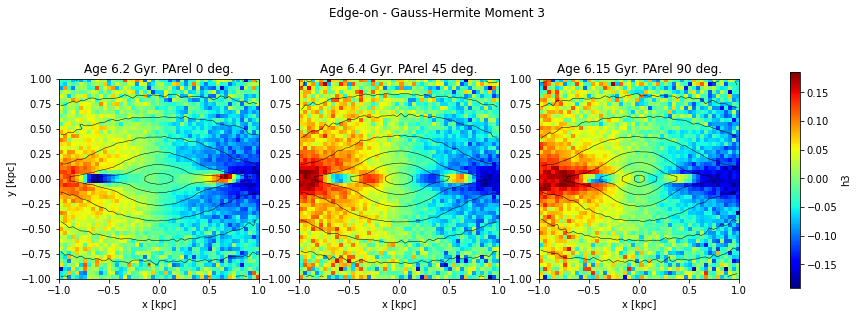

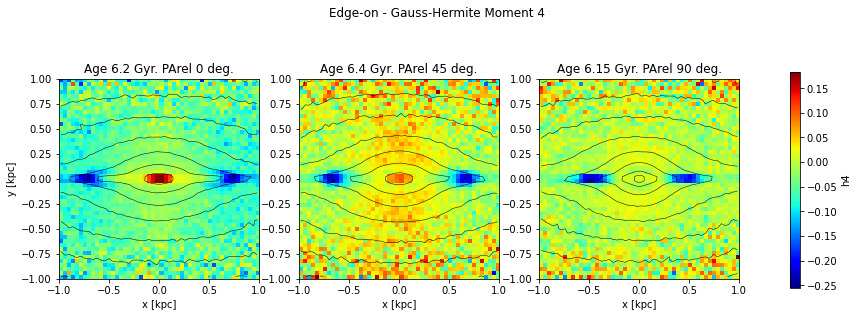

In [17]:
# Zoom in
#xy_lim = [[5,5],[1,1],[0.5,0.5]] #kpc
#xlim, ylim = 0.5, 0.5 #kpc
xlim, ylim = 1, 1 #kpc
#xlim, ylim = 7, 7 #kpc
plt_title = 'Edge-on - Gauss-Hermite Moment '
cbar_label = 'h'
incl = 90
m_lst = [3,4]
bins = 50
#cmap = 'seismic'
cmap = 'jet'

for m in m_lst:
    # make the figure and sub plots
    fig,axes = plt.subplots(1,3,figsize=(14,5))
    
    i = 0
    for s in s_lst:

        age = round(s.properties['time'].in_units('Gyr'),2)

        s.rotate_x(-incl)
        
        d_stat2d,d_xedges,d_yedges,d_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                      statistic = 'count',
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
        
        stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)

        image = axes[i].imshow(stat2d.T, 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)

        axes[i].title.set_text('Age ' + str(age) + ' Gyr.' + ' PArel ' + str(45*i) + ' deg.')

        xcent = (d_xedges[1:] + d_xedges[:-1]) / 2
        ycent = (d_yedges[1:] + d_yedges[:-1]) / 2
        axes[i].contour(xcent, ycent, np.log10(d_stat2d.T), linewidths = 0.5, colors = 'k')
    
        i = i + 1
    
        s.rotate_x(incl) # Rotate back to original position
    
    fig.subplots_adjust(right = 0.8)
    cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.6])
    cbar = fig.colorbar(image, cax = cbar_ax)
    cbar.set_label(cbar_label + str(m))
    fig.suptitle(plt_title + str(m))
    plt.setp(axes[:], xlabel = 'x [kpc]')
    plt.setp(axes[0], ylabel = 'y [kpc]')
    plt.savefig('run732HF_h' + str(m) + '.png')
    plt.show()
    

#### Edge-on velocity distribution map series

* Loading data from file /home/ubuntu/projects/S2B/models/S1B_nogas_models/run761AV.02000.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 113.04864093639446 degrees
* Rotating the primary bar to PA 90 deg
* Tilting the galactic plane to 90 deg.


/tmp/ipykernel_502/1508006324.py:114: RuntimeWarning: divide by zero encountered in log10
  axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')


* Tilting the galactic plane back to -90 deg.
* Rotating the primary bar back PA = 0
* Done!


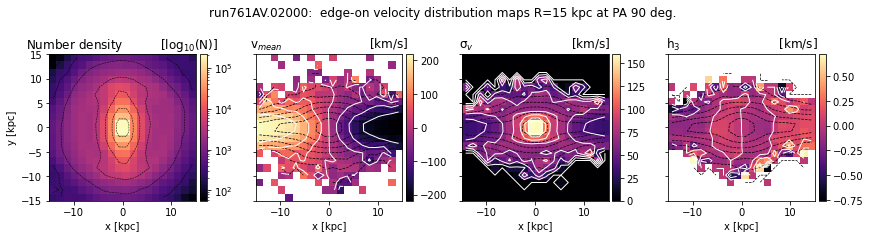

* Loading data from file /home/ubuntu/projects/S2B/models/S1B_nogas_models/run761BP.02000.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 112.59277881250675 degrees
* Rotating the primary bar to PA 90 deg
* Tilting the galactic plane to 90 deg.


/tmp/ipykernel_502/1508006324.py:114: RuntimeWarning: divide by zero encountered in log10
  axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')


* Tilting the galactic plane back to -90 deg.
* Rotating the primary bar back PA = 0
* Done!


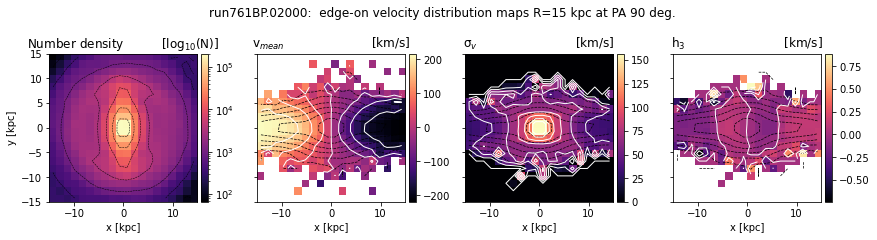

* Loading data from file /home/ubuntu/projects/S2B/models/S1B_nogas_models/run761CK.02400.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -179.7484391903921 degrees
* Rotating the primary bar to PA 90 deg
* Tilting the galactic plane to 90 deg.


/tmp/ipykernel_502/1508006324.py:114: RuntimeWarning: divide by zero encountered in log10
  axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')


* Tilting the galactic plane back to -90 deg.
* Rotating the primary bar back PA = 0
* Done!


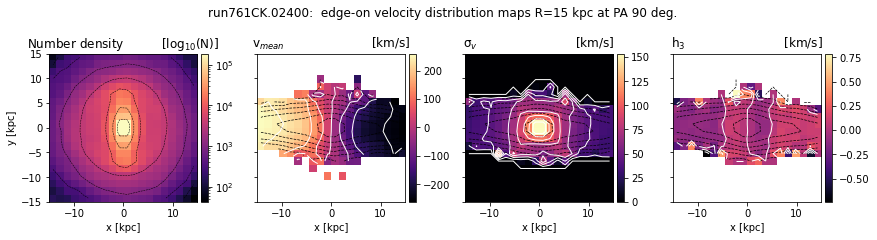

* Loading data from file /home/ubuntu/projects/S2B/models/S1B_nogas_models/run761CL.02400.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -160.90383324344756 degrees
* Rotating the primary bar to PA 90 deg
* Tilting the galactic plane to 90 deg.


/tmp/ipykernel_502/1508006324.py:114: RuntimeWarning: divide by zero encountered in log10
  axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')


* Tilting the galactic plane back to -90 deg.
* Rotating the primary bar back PA = 0
* Done!


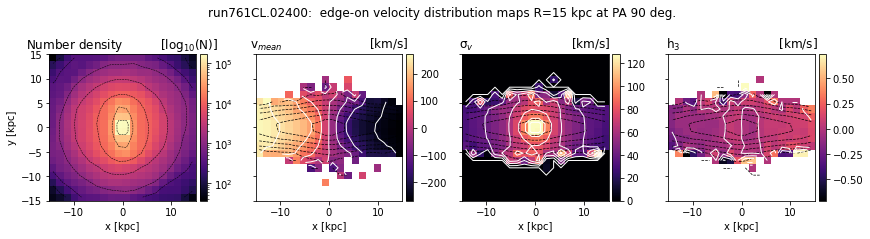

In [2]:
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
#xlim, ylim = 1, 1 #kpc
#xylim_lst = [1,2,5] #kpc
xylim_lst = [15] #kpc
bins = 20
cmap = 'magma'
plt_title = ' edge-on velocity distribution maps'
splt_title_lst = ['Number density          [log$_{10}$(N)]',
                  'v$_{mean}$                       [km/s]',
                  'σ$_{v}$                          [km/s]',
                  'h$_{3}$                          [km/s]']
cbar_label_lst = ['log$_{10}$(N)',
                  'v$_{mean}$ [km/s]',
                  'σ$_{v}$    [km/s]',
                  'h$_{3}$    [km/s]',]

panels = 4
figsize_x = 3*panels
figsize_y = 3.5

incl = 90
pa_lst = [90]

for snap in snap_lst:
    for xylim in xylim_lst:
        # Define zoom-in area
        xlim = xylim
        ylim = xylim
        for pa in pa_lst:
    
            stat2d_lst = []
        
            # make the figure and sub plots
            fig,axes = plt.subplots(1,panels,figsize=(figsize_x,figsize_y))
    
            # Load snapshot data, center face-on, align primary bar using inertia tensor
            snap_name = snap.replace('.gz','')
            param_fname = [param for param in param_lst if param.replace('.param','') in snap_name]
            #print(param_fname[0])
            s = pbload(base_dir + str(snap),base_dir + str(param_fname[0]),log = True)
            #s = pbload(base_dir + snap,param_fname,log=True)
    
            # Snapshot age
            age = round(s.properties['time'].in_units('Gyr'),2)
    
            if pa > 0:
                s.rotate_z(-pa)
                print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
            # Number density statistics face-on for inner bar reference plot
            df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(df_stat2d.T)
        
            # Tilt to inclinantion
            print('* Tilting the galactic plane to ' + str(incl) + ' deg.')
            s.rotate_x(-incl) 
    
            # Number density statistics for velocity maps density contours
            de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
    
            # Mean velicity statistics
            v_stat2d,v_xedges,v_yedges,v_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(v_stat2d.T)
    
            # Velocity dispersion statistics
            vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
            stat2d_lst.append(vd_stat2d.T)
    
            # Gauss-Hermite h3 moment
            h3_stat2d,h3_xedges,h3_yedges,h3_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 3),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h3_stat2d.T)
    
            # Gauss-Hermite h4 moment
            h4_stat2d,h4_xedges,h4_yedges,h4_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                      statistic = lambda bin_values: GaussHermiteMoment(bin_values, 4),
                                      range = [[-xlim,xlim],[-ylim,ylim]],
                                      bins = bins)
            stat2d_lst.append(h4_stat2d.T)
    
            for i in range(panels):
                if i == 0:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            norm = LogNorm(),
                            cmap = cmap)
                    xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                    ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
                else:
                    image = axes[i].imshow(stat2d_lst[i], 
                            origin = 'lower',
                            extent = [-xlim, xlim, -ylim, ylim ],
                            cmap = cmap)
                    xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                    ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                    xcent = (v_xedges[1:] + v_xedges[:-1]) / 2
                    ycent = (v_yedges[1:] + v_yedges[:-1]) / 2
                    axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
                axes[i].title.set_text(splt_title_lst[i])
                divider = make_axes_locatable(axes[i])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(image, cax=cax, orientation='vertical')
                #cbar.set_label(cbar_label_lst[i])
                if i > 0:
                    axes[i].set_yticklabels([])

            print('* Tilting the galactic plane back to ' + str(-incl) + ' deg.')
            s.rotate_x(incl) # Tilt back to face-on
            
            if pa > 0:
                print('* Rotating the primary bar back PA = 0')
                s.rotate_z(pa)
            
            fig.tight_layout()
            #fig.suptitle(snap_lst[j].replace(".gz",": ") + plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
            fig.suptitle(snap.replace(".gz",": ") + plt_title + ' R=' + str(xlim) + ' kpc' + ' at ' + 'PA ' + str(pa) + ' deg.')
            plt.setp(axes[:], xlabel = 'x [kpc]')
            plt.setp(axes[0], ylabel = 'y [kpc]')
            plt.savefig(image_dir + snap.replace(".gz","") + '_LOSVD_h3_h4_' + str(xlim) + 'kpc' + '_pa' + str(pa) + '.png')
            print('* Done!')
            plt.show()
    

#### Edge-on sigma maps by age

In [5]:
from matplotlib.backends.backend_pdf import PdfPages

# Zoom in
#xlim, ylim = 5, 5 #kpc
xlim, ylim = 2, 2 #kpc
#xlim, ylim = 1, 1 #kpc
#pdf_fname = image_dir + 'run732HF_sigma_maps_by_age_' + str(xlim) + 'kpc.pdf'
bins = 50
cmap = 'jet'
plt_title = 'Edge-on sigma distribution maps by age'
splt_title_lst = ['Face-on num density  [log10(N)]',
                  'Sigma youngest 1/3   [km/s]',
                  'Sigma intermed 1/3   [km/s]',
                  'Sigma oldest 1/3     [km/s]']
cbar_label_lst = ['Log10(N)',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]']
incl = 90
pa_lst = [0]

# create a PdfPages object
#pdf = PdfPages(pdf_fname)

for pa in pa_lst:
    #snap_count = 0
    for snap in snap_lst:
    
        stat2d_lst = []
        
        # make the figure and sub plots
        fig,axes = plt.subplots(1,4,figsize=(14,3.5))
    
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        s = pbload(base_dir + snap,param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        if pa > 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
        # Number density statistics face-on for inner bar reference plot
        df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(df_stat2d.T)
        
        # Rotate to edge-on view
        s.rotate_x(-incl) 
    
        # Divide snapshot into 3 age groups
        max_age = round(max(s.star['age']),2)
        #print('Snap max age - ' + str(max_age) + 'Gyr')
        #print('Total stars in snap - ', len(s.star))
    
        # Number density statistics for velocity maps density contours
        de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
 
        # Velocity dispersion statistics per age group
        
        mask = s.star['age'] < max_age/3
        #print(len(mask))
        s_grp = s.star[mask]
        #print('Stars in youngest 1/3 - ', len(s_grp.star['age']))
        
        vd1_stat2d,vd1_xedges,vd1_yedges,vd1_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd1_stat2d.T)

        mask = ma.masked_inside(s.star['age'], max_age/3, 2*max_age/3).mask
        #print(len(mask))
        s_grp = s.star[mask]
        #print('Stars in intermediate 1/3 - ', len(s_grp['age']))
        
        vd2_stat2d,vd2_xedges,vd2_yedges,vd2_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd2_stat2d.T)
        
        mask =  s.star['age'] > 2*max_age/3
        #print(len(mask))
        s_grp = s.star[mask]
        #print('Stars in oldest 1/3 - ', len(s_grp['age']))
        
        vd3_stat2d,vd3_xedges,vd3_yedges,vd3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd3_stat2d.T)
    
        for i in range(4):
            if i == 0:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            else:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd1_xedges[1:] + vd1_xedges[:-1]) / 2
                ycent = (vd1_yedges[1:] + vd1_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
            axes[i].title.set_text(splt_title_lst[i])
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])
    
        # s.rotate_x(incl) # Rotate back to original position
    
        fig.tight_layout()
        fig.suptitle(plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
        plt.setp(axes[:], xlabel = 'x [kpc]')
        plt.setp(axes[0], ylabel = 'y [kpc]')
        plt.savefig(image_dir + snap.replace(".gz","") + '_sigma_by_age_' + str(xlim) + 'kpc_pa' + str(pa) + '.png')
        print('* Done!')
        #plt.show()
        
        # save plot using savefig() method of pdf object
        #pdf.savefig(fig)
        #snap_count = snap_count + 1

        # Close the object to ensure writing multiple plots
        #if snap_count == 5:
        #    pdf.close()
    

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656133 degrees
* Done!
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 174.59931084286313 degrees
* Done!
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 88.64641316008235 degrees
* Done!
* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01230.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -172.62155486404146 degrees
* Done!
* Loading data from file /home/ubuntu/projects/S2B/models

: 

: 

#### Edge-on sigma maps by age 2

We group together age grousp 2 and 3, leaving the oldest 1/3 as a separate group.

In [1]:
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
xlim, ylim = 1, 1 #kpc
bins = 50
cmap = 'jet'
plt_title = 'Edge-on sigma distribution maps by age'
splt_title_lst = ['Face-on total density  [log10(N)]',
                  'Face-on group 1-2 density  [log10(N)]',
                  'Sigma group 1-2      [km/s]',
                  'Sigma oldest 1/3     [km/s]']
cbar_label_lst = ['Log10(N)',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]']
incl = 90
pa_lst = [0]

for pa in pa_lst:
    #snap_count = 0
    for snap in snap_lst:
    
        stat2d_lst = []
        
        # make the figure and sub plots
        fig,axes = plt.subplots(1,4,figsize=(14,3.5))
    
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        s = pbload(base_dir + snap,param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        if pa > 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
        # Number density statistics face-on for inner bar reference plot
        df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(df_stat2d.T)
        
        # Divide snapshot into 2 age groups
        max_age = round(max(s.star['age']),2)
        #print('Snap max age - ' + str(max_age) + 'Gyr')
        #print('Total stars in snap - ', len(s.star))
        
        mask = s.star['age'] < 2*max_age/3
        #print(len(mask))
        s_grp = s.star[mask]
        #print('Stars in youngest 2/3 - ', len(s_grp.star['age']))
        
        # Number density statistics face-on for group 1-2 stellar population
        dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(dfg_stat2d.T)
        
        # Rotate to edge-on view
        s.rotate_x(-incl) 
    
        # Number density statistics for velocity maps density contours
        de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
 
        
        # Velocity dispersion statistics per age group
        
        vd1_stat2d,vd1_xedges,vd1_yedges,vd1_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd1_stat2d.T)

        mask =  s.star['age'] > 2*max_age/3
        #print(len(mask))
        s_grp = s.star[mask]
        #print('Stars in oldest 1/3 - ', len(s_grp['age']))
        
        vd3_stat2d,vd3_xedges,vd3_yedges,vd3_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd3_stat2d.T)
    
        for i in range(4):
            if i == 0:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            elif i == 1:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(dfg_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            else:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd1_xedges[1:] + vd1_xedges[:-1]) / 2
                ycent = (vd1_yedges[1:] + vd1_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
            axes[i].title.set_text(splt_title_lst[i])
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])
    
        # s.rotate_x(incl) # Rotate back to original position
    
        fig.tight_layout()
        fig.suptitle(plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
        plt.setp(axes[:], xlabel = 'x [kpc]')
        plt.setp(axes[0], ylabel = 'y [kpc]')
        plt.savefig(image_dir + snap.replace(".gz","") + '_sigma_by_age_2grp_' + str(xlim) + 'kpc_pa' + str(pa) + '.png')
        print('* Done!')
        plt.show()   

NameError: name 'snap_lst' is not defined

#### Edge-on sigma maps by age 3

We plot
- face-on total number density
- face-on group 1-2 number density
- face-on group 3 part 1 number dencity
- face-on group 3 part 2 number dencity
- edge-on group 1-2 sigma
- edge-on group 3 part 1 sigma
- edge-on group 3 part 2 sigma

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01200.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 76.86466203656133 degrees
* Done!


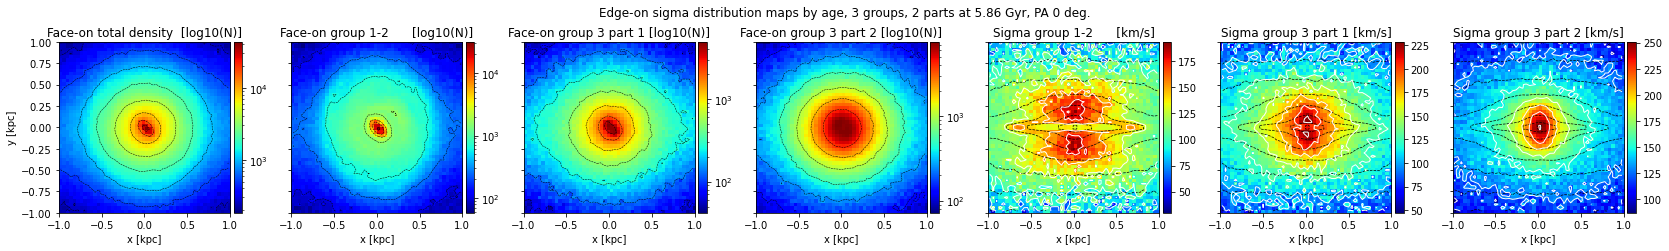

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01210.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 174.599310842863 degrees
* Done!


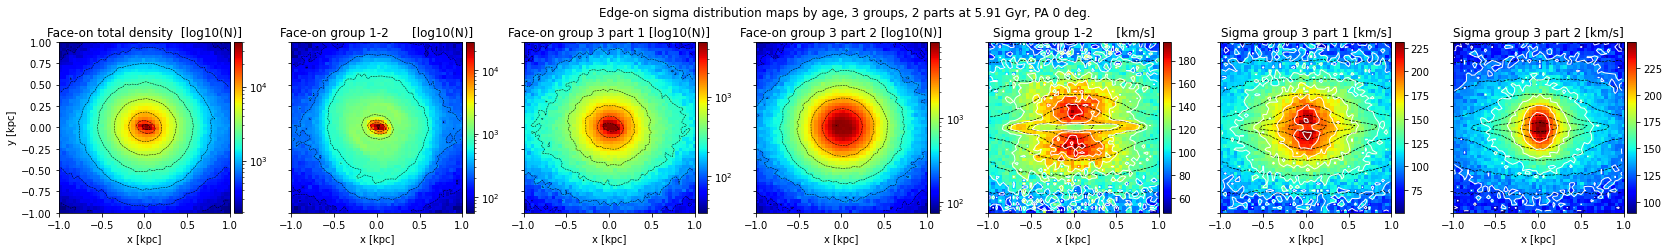

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01220.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 88.64641316008235 degrees
* Done!


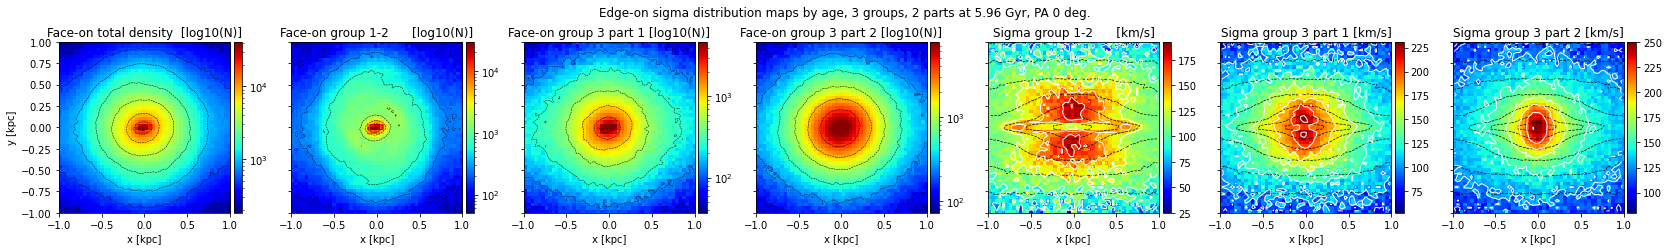

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01230.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -172.62155486404146 degrees
* Done!


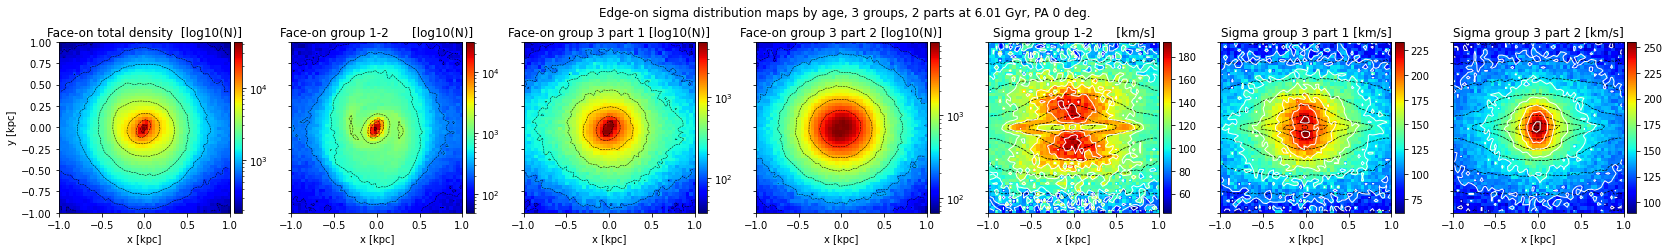

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01240.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.69997384566695 degrees
* Done!


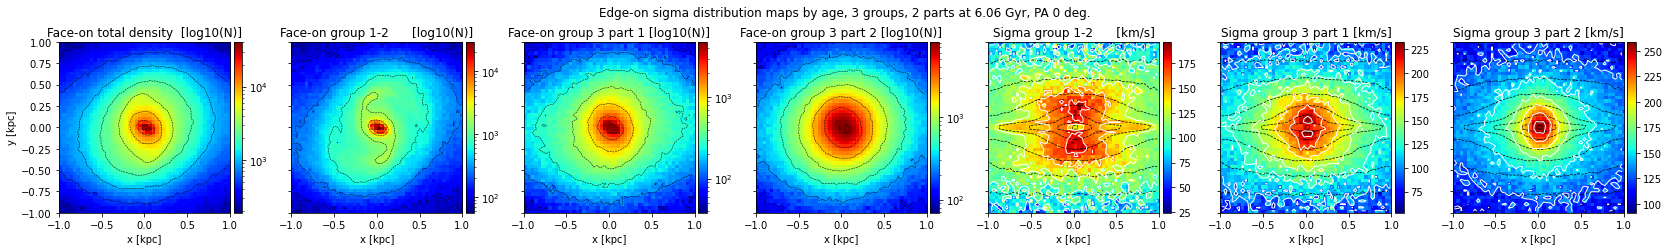

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01250.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -167.08701143655207 degrees
* Done!


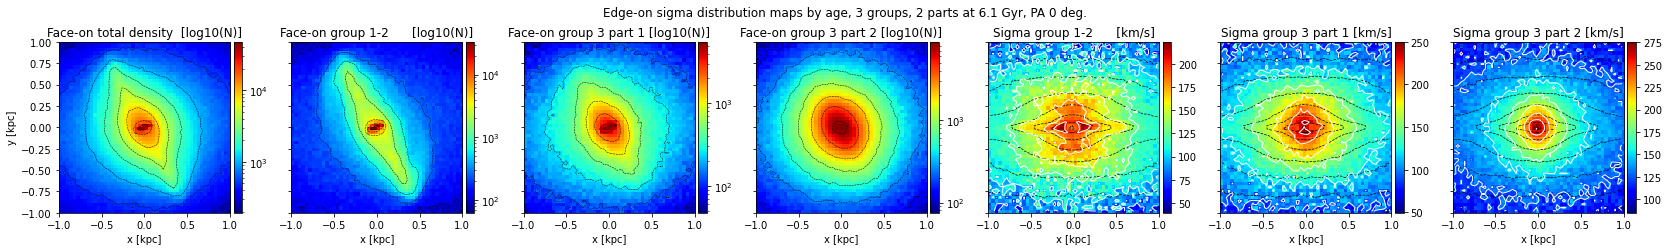

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01260.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 103.18405996483042 degrees
* Done!


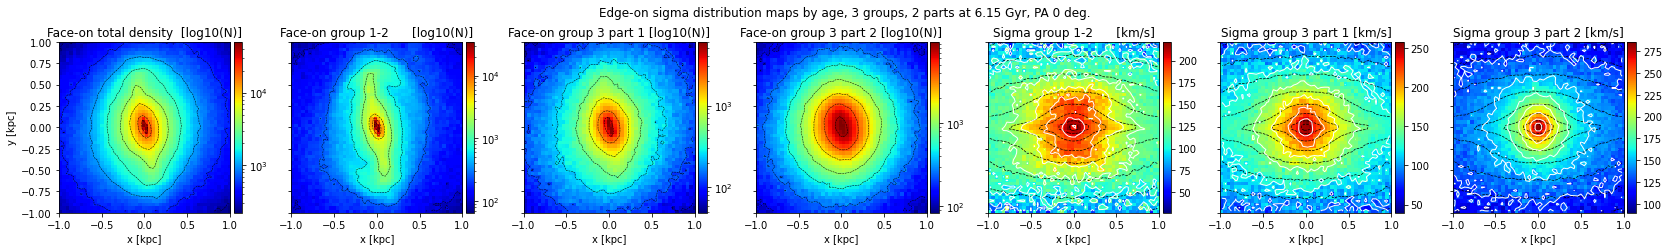

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01270.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 46.977492810664934 degrees
* Done!


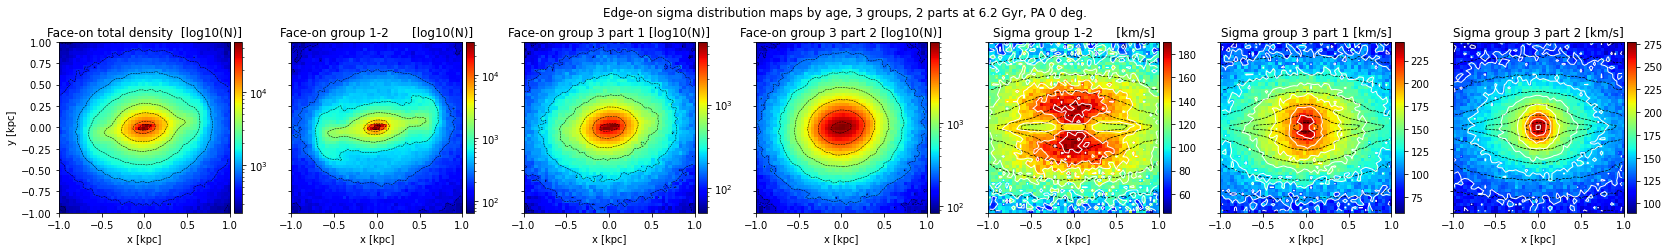

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01280.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 179.4765536288629 degrees
* Done!


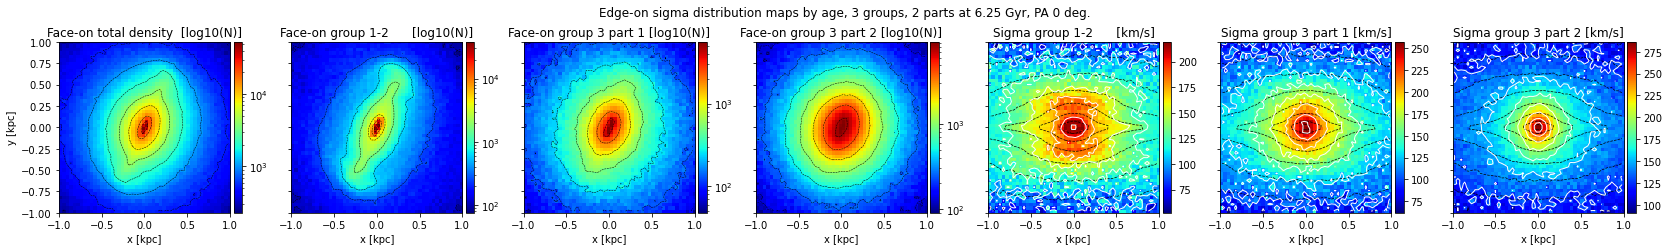

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01290.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 80.98668426330768 degrees
* Done!


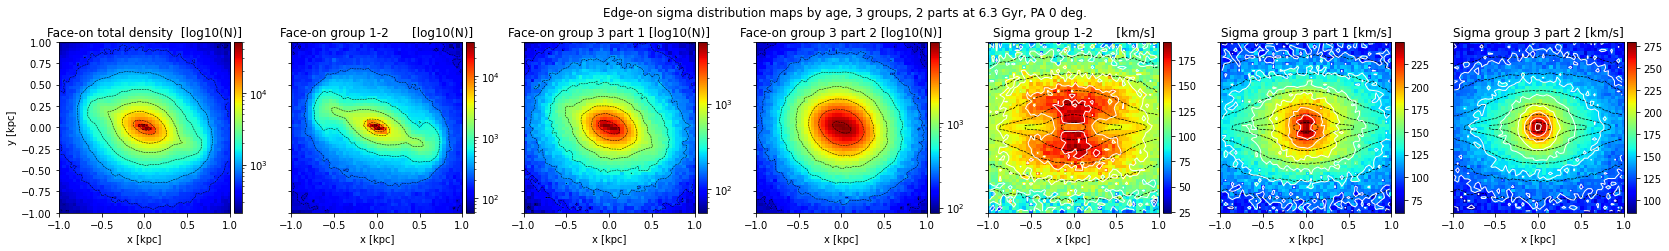

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01300.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -164.49311371554302 degrees
* Done!


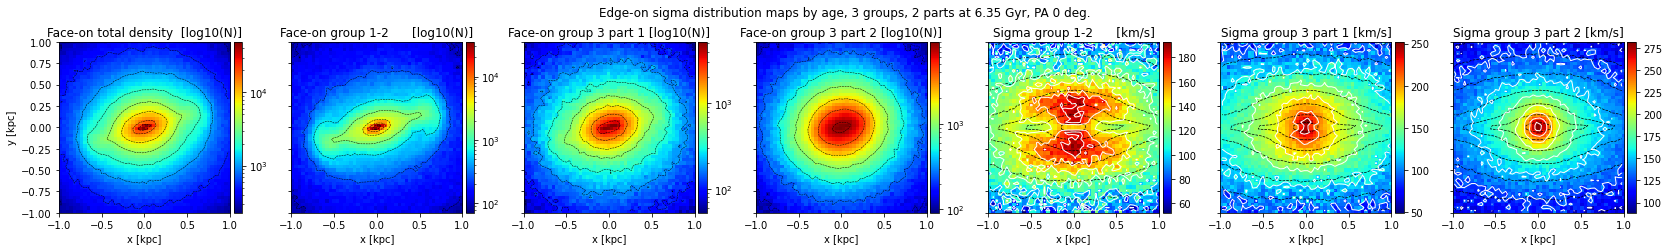

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01310.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 127.40061832790695 degrees
* Done!


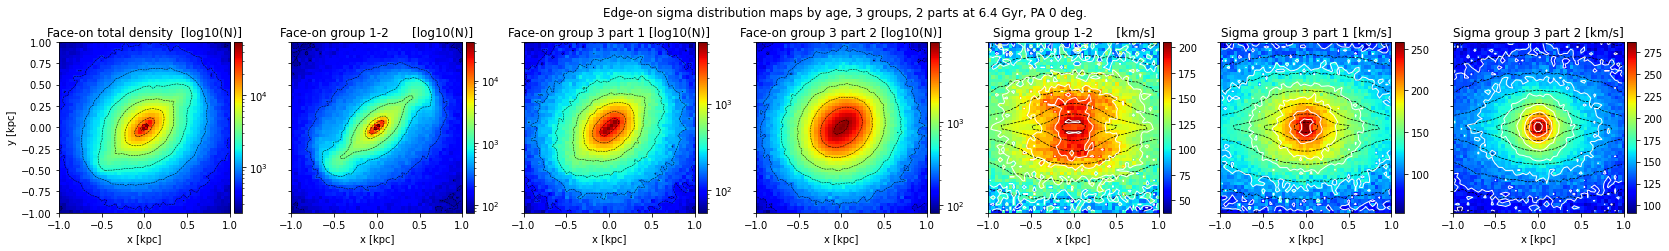

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01320.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 84.71445997281806 degrees
* Done!


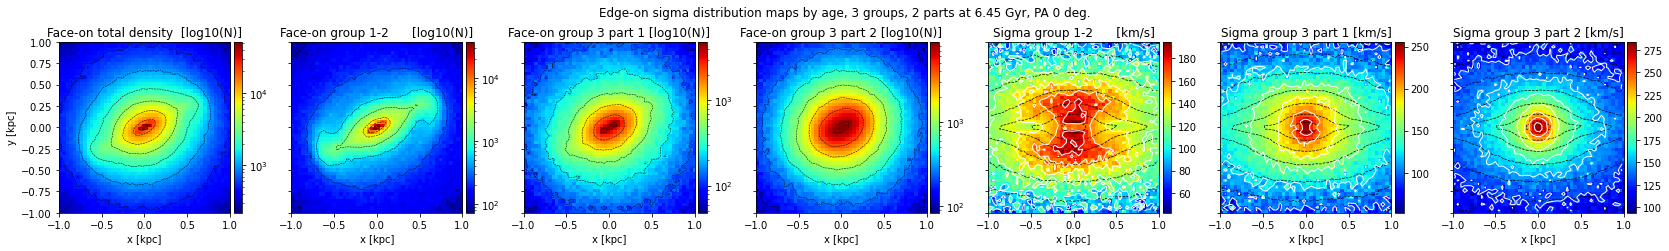

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01330.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -159.6927806294851 degrees
* Done!


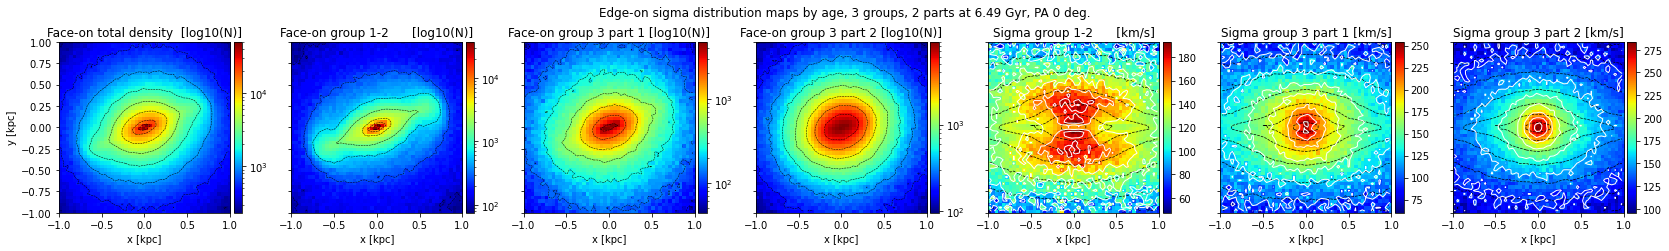

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01340.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 145.48701448074962 degrees
* Done!


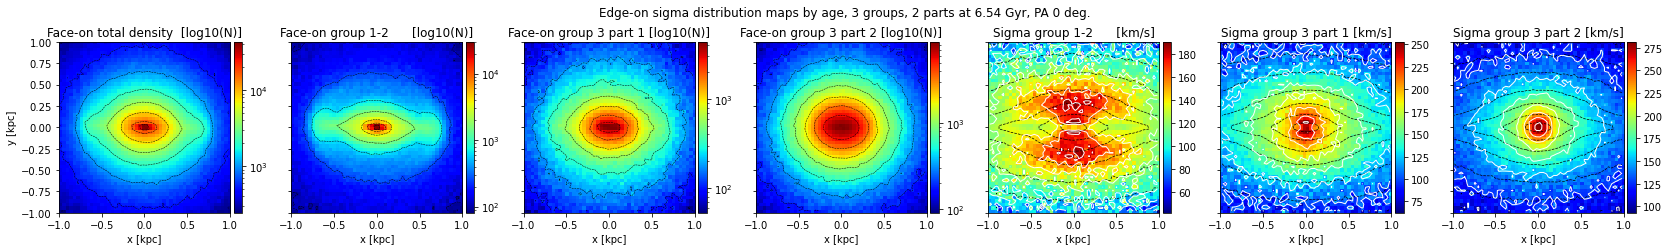

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01350.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -145.0096509512555 degrees
* Done!


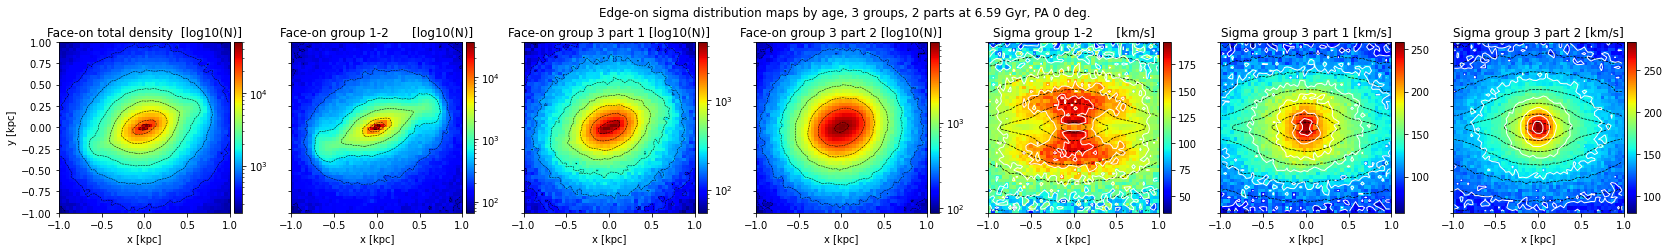

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01360.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -169.9926244800207 degrees
* Done!


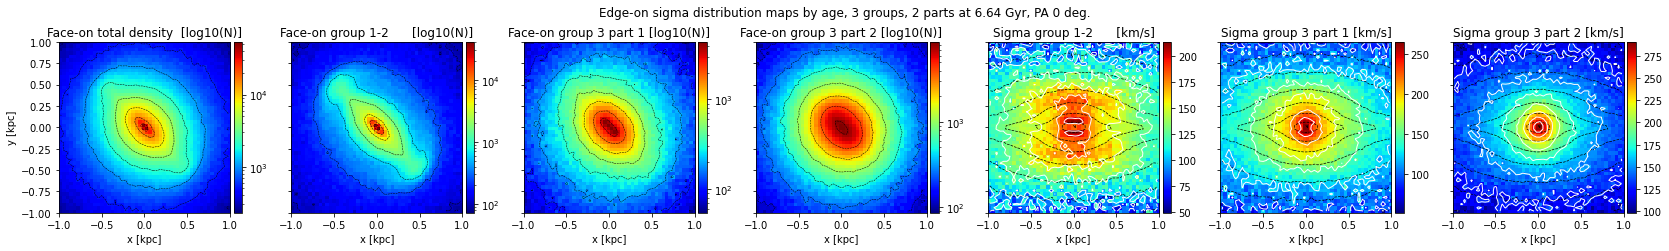

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01370.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -149.44800369995644 degrees
* Done!


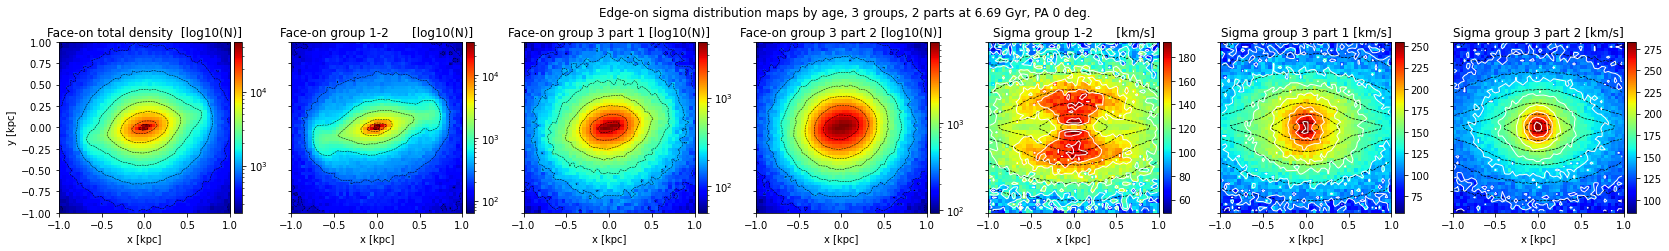

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01380.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by -149.53226537413826 degrees
* Done!


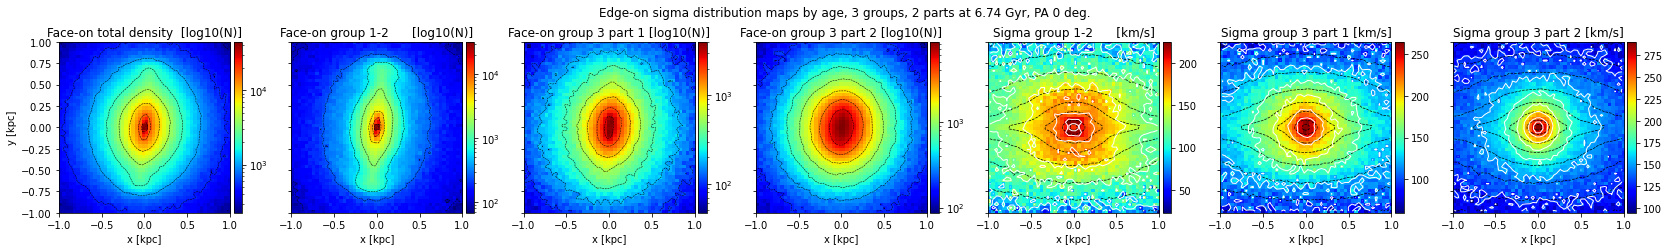

* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01390.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 171.5173462072431 degrees
* Done!


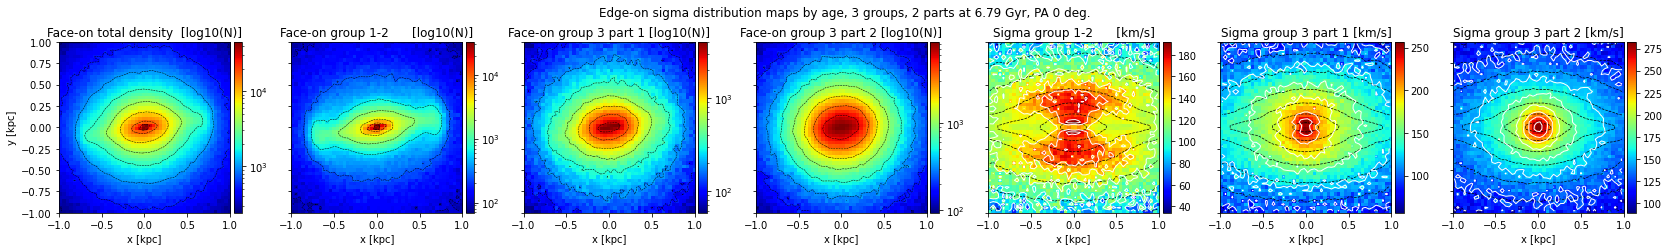

In [3]:
# Zoom in
#xlim, ylim = 5, 5 #kpc
#xlim, ylim = 2, 2 #kpc
xlim, ylim = 1, 1 #kpc
bins = 50
cmap = 'jet'
plt_title = 'Edge-on sigma distribution maps by age, 3 groups, 2 parts'
splt_title_lst = ['Face-on total density  [log10(N)]',
                  'Face-on group 1-2      [log10(N)]',
                  'Face-on group 3 part 1 [log10(N)]',
                  'Face-on group 3 part 2 [log10(N)]',
                  'Sigma group 1-2      [km/s]',
                  'Sigma group 3 part 1 [km/s]',
                  'Sigma group 3 part 2 [km/s]']
cbar_label_lst = ['Log10(N)',
                  'Log10(N)',
                  'Log10(N)',
                  'Log10(N)',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]',
                  'sigma_v [km/s]']
incl = 90
pa_lst = [0]

for pa in pa_lst:
    #snap_count = 0
    for snap in snap_lst:
    
        stat2d_lst = []
        
        snap_name = snap.replace('.gz','')
        
        param_fname = [s for s in param_lst if snap_name in s]
        
        # make the figure and sub plots
        fig,axes = plt.subplots(1,7,figsize=(23,3.5))
    
        # Load snapshot data, center face-on, align primary bar using inertia tensor
        s = pbload(base_dir + snap,param_fname,log=True)
    
        # Snapshot age
        age = round(s.properties['time'].in_units('Gyr'),2)
    
        if pa > 0:
            s.rotate_z(-pa)
            print('* Rotating the primary bar to PA ' + str(pa) + ' deg')
        
        # Number density statistics face-on for inner bar reference plot
        #
        # face-on total number dencity
        #
        df_stat2d,df_xedges,df_yedges,df_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(df_stat2d.T)
        
        # Divide snapshot into 2 age groups
        max_age = round(max(s.star['age']),2)
        
        #
        # face-on group 1-2 number density
        #
        mask = s.star['age'] < 2*max_age/3
        s_grp = s.star[mask]
        
        # Number density statistics face-on for group 1-2 stellar population
        dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(dfg_stat2d.T)
        
        #
        # face-on group 3 part 1 number density
        #
        mask = ma.masked_inside(s.star['age'], 2*max_age/3, 5*max_age/6).mask
        s_grp = s.star[mask]
        
        # Number density statistics face-on for group 3 part 1 stellar population
        dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(dfg_stat2d.T)
        
        #
        # face-on group 3 part 2 number density
        #
        mask = s.star['age'] > 5*max_age/6
        s_grp = s.star[mask]
        
        # Number density statistics face-on for group 3 part 2 stellar population
        dfg_stat2d,dfg_xedges,dfg_yedges,dfg_binnum2d = st.binned_statistic_2d(s_grp['x'], s_grp['y'], s_grp['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(dfg_stat2d.T)
                
        # Rotate to edge-on view
        s.rotate_x(-incl) 
    
        # Number density statistics for velocity maps density contours
        de_stat2d,de_xedges,de_yedges,de_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
 
        
        # Velocity dispersion statistics per age group
        
        #
        # edge-on group 1-2 sigma
        #
        mask = s.star['age'] < 2*max_age/3
        s_grp = s.star[mask]

        vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd_stat2d.T)

        #
        # edge-on group 3 part 1 sigma
        #
        mask = ma.masked_inside(s.star['age'], 2*max_age/3, 5*max_age/6).mask
        s_grp = s.star[mask]
        
        vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd_stat2d.T)

        #
        # edge-on group 3 part 2 sigma
        #
        mask = s.star['age'] > 5*max_age/6
        s_grp = s.star[mask]
        
        vd_stat2d,vd_xedges,vd_yedges,vd_binnum2d = st.binned_statistic_2d(s_grp.star['x'], s_grp.star['y'], s_grp.star['vz'],
                                  statistic = 'std',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        stat2d_lst.append(vd_stat2d.T)
            
        for i in range(7):
            if i == 0:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (df_xedges[1:] + df_xedges[:-1]) / 2
                ycent = (df_yedges[1:] + df_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(df_stat2d.T), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            elif i == 1:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(stat2d_lst[i]), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            elif i == 2:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(stat2d_lst[i]), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            elif i == 3:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        norm = LogNorm(),
                        cmap = cmap)
                xcent = (dfg_xedges[1:] + dfg_xedges[:-1]) / 2
                ycent = (dfg_yedges[1:] + dfg_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(stat2d_lst[i]), linewidths = 0.5, linestyles = 'dashed', colors = 'k')
            else:
                image = axes[i].imshow(stat2d_lst[i], 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)
                xcent = (de_xedges[1:] + de_xedges[:-1]) / 2
                ycent = (de_yedges[1:] + de_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, np.log10(de_stat2d.T), linewidths = 0.7, linestyles = 'dashed', colors = 'k')
                xcent = (vd_xedges[1:] + vd_xedges[:-1]) / 2
                ycent = (vd_yedges[1:] + vd_yedges[:-1]) / 2
                axes[i].contour(xcent, ycent, stat2d_lst[i], linewidths = 1, linestyles = 'solid', colors = 'w')
        
            axes[i].title.set_text(splt_title_lst[i])
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(image, cax=cax, orientation='vertical')
            #cbar.set_label(cbar_label_lst[i])
            if i > 0:
                axes[i].set_yticklabels([])
    
        # s.rotate_x(incl) # Rotate back to original position
    
        fig.tight_layout()
        fig.suptitle(plt_title + ' at ' + str(age) + ' Gyr, ' + 'PA ' + str(pa) + ' deg.')
        plt.setp(axes[:], xlabel = 'x [kpc]')
        plt.setp(axes[0], ylabel = 'y [kpc]')
        plt.savefig(image_dir + snap.replace(".gz","") + '_sigma_by_age_2grp2part_' + str(xlim) + 'kpc_pa' + str(pa) + '.png')
        print('* Done!')
        plt.show()   